# The Project #
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images . The task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. 


In [1]:
import zipfile

from PIL import Image
import pytesseract
import cv2 as cv
import numpy as np
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

First consider the data structure: list of dictionaries.

In [2]:
class newspaper:
    #store the information of a paper
    #param name: filename
    #param image: the original image
    #param bow(str): bag of words in the newspaper
    #param faces(list): bag of faces in the newspaper
    #param face_number: number of faces detected
    def __init__(self, name, image, bow, faces, face_number):
        self.name = name
        self.image = image
        self.bow = bow
        self.faces = faces
        self.number = face_number
    
    def checkword(self, key_word):
        if key_word in self.bow:
            return 1
        else:
            return 0

getting the text information in the image

In [3]:
def binarize(image_to_transform, threshold):
    output_image=image_to_transform.convert("L")
    for x in range(output_image.width):
        for y in range(output_image.height):
            if output_image.getpixel((x,y))< threshold: 
                output_image.putpixel( (x,y), 0 )
            else:
                output_image.putpixel( (x,y), 255 )
    return output_image

In [4]:
def get_words(image):
    text = pytesseract.image_to_string(binarize(image,255))
    return text

detecting faces in the newspaper

In [5]:
def sort_by_desc(facelist):
    l = len(facelist)
    for i in range(l-1):
        for j in range(i,l):
            if facelist[i].height < facelist[j].height:
                temp = facelist[i]
                facelist[i] = facelist[j]
                facelist[j] = temp
    return facelist

In [6]:
def construct_contact_sheet(facelist):
    #resize the faces
    for face in facelist:
        face.thumbnail((128, 128))
    #sort by the facesize desc
    facelist = sort_by_desc(facelist)
    #creating the contact sheet
    first_face = facelist[0]
    if len(facelist)%5==0:
        row = int(len(facelist)/5)
    else:
        row = int(len(facelist)/5)+1
    contact_sheet = Image.new(first_face.mode, (first_face.width*5,first_face.height*row))
    x = 0
    y = 0
    for face in facelist:
        contact_sheet.paste(face, (x, y) )
        if x+first_face.width == contact_sheet.width:
            x = 0
            y = y+first_face.height
        else:
            x = x+first_face.width
    return contact_sheet

In [25]:
def get_faces(img,cv_img):
    faces = face_cascade.detectMultiScale(cv_img,1.3,6)
    facelist = []
    for x,y,w,h in faces:
        new_face = img.crop((x,y,x+w,y+h))
        facelist.append(new_face)
    if len(facelist)==0:
        contact_sheet = Image.new("RGB",(103,103))
    else:
        contact_sheet = construct_contact_sheet(facelist)
    return contact_sheet, len(facelist)


preprocess:open the zipfile and create the newspaperlist

In [9]:
def zip_process(path):
    papers =  []
    zipf = zipfile.ZipFile(path)
    infolist = zipf.infolist()
    for info in infolist:
        file =  zipf.open(info)
        image = Image.open(file)
    
        cv_file = zipf.read(info)
        cv_image = cv.imdecode(np.frombuffer(cv_file, np.uint8), 1)   

        name = info.filename
        bag_of_words = get_words(image)
        faces, face_number = get_faces(image,cv_image)
        page = newspaper(name, image, bag_of_words, faces, face_number)
        papers.append(page)
    return papers

the query function

In [10]:
def query_by_keyword(papers,key_word):
    for page in papers:
        if page.checkword(key_word):
            print("Results found in %s"%(page.name))
            if page.number == 0:
                print("But the were no faces in that file!")
            else:
                display(page.faces)

main call

Results found in a-0.png


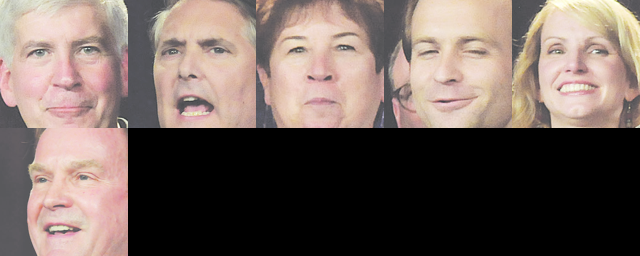

Results found in a-1.png


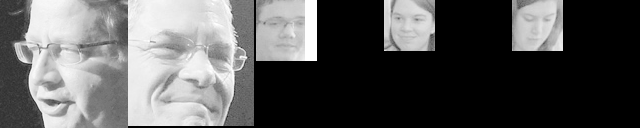

Results found in a-10.png
But the were no faces in that file!
Results found in a-13.png


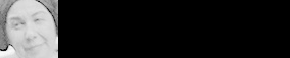

Results found in a-2.png


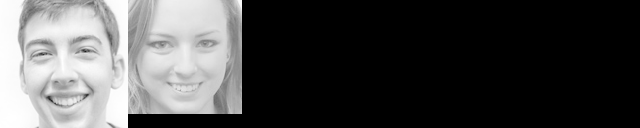

Results found in a-3.png


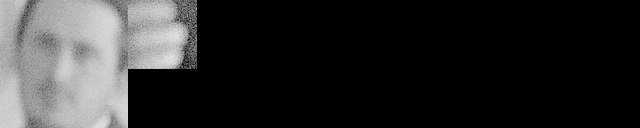

Results found in a-8.png
But the were no faces in that file!


In [27]:
papers = zip_process("readonly/images.zip")
query_by_keyword(papers,"Mark")

test function

Results found in a-0.png


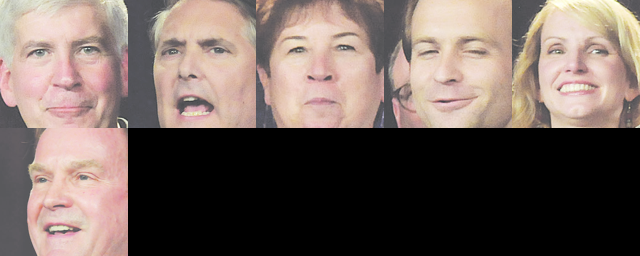

Results found in a-3.png


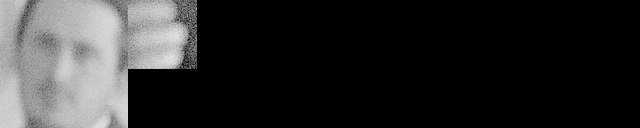

In [28]:
papers = zip_process("readonly/small_img.zip")
query_by_keyword(papers,"Christopher")